In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv, os
from prettytable import PrettyTable

### First, need to compute macro-Recall.

In [2]:
base_input_dir = 'metrics/matrix/'
output_file = 'metrics/merged_macro_micro_recall.csv'

def read_matrix(file_path):
    df = pd.read_csv(file_path, index_col=0)
    return df.values

def macro_rec(confusion_matrix):
    recalls = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    return np.mean(recalls)

def micro_rec(confusion_matrix):
    true_positives = np.diag(confusion_matrix)
    total_true_positives = np.sum(true_positives)
    total_actual_positives = np.sum(confusion_matrix)
    return total_true_positives / total_actual_positives

results = []

# Iterate over all confusion matrices.
for i in range(1, 500):  
    input_file = f'{base_input_dir}xgb_df{i}_matrix.csv'

    confusion_matrix = read_matrix(input_file)
    
    # Obtain macro and micro recall.
    macro_recall = macro_rec(confusion_matrix)
    micro_recall = micro_rec(confusion_matrix)
    results.append({
        'Model': str(i),
        'micro_recall': f'{micro_recall:.4f}',
        'macro_recall': f'{macro_recall:.4f}',
        'confusion_matrix': confusion_matrix.tolist()
    })
    
    print(f"Processed model: {i}")

# Write to disk.
with open(output_file, 'w', newline='') as csvfile:
    fieldnames = ['Model', 'micro_recall', 'macro_recall', 'confusion_matrix']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in results:
        writer.writerow(row)

print(f"Saved to {output_file}")

Processed model: 1
Processed model: 2
Processed model: 3
Processed model: 4
Processed model: 5
Processed model: 6
Processed model: 7
Processed model: 8
Processed model: 9
Processed model: 10
Processed model: 11
Processed model: 12
Processed model: 13
Processed model: 14
Processed model: 15
Processed model: 16
Processed model: 17
Processed model: 18
Processed model: 19
Processed model: 20
Processed model: 21
Processed model: 22
Processed model: 23
Processed model: 24
Processed model: 25
Processed model: 26
Processed model: 27
Processed model: 28
Processed model: 29
Processed model: 30
Processed model: 31
Processed model: 32
Processed model: 33
Processed model: 34
Processed model: 35
Processed model: 36
Processed model: 37
Processed model: 38
Processed model: 39
Processed model: 40
Processed model: 41
Processed model: 42
Processed model: 43
Processed model: 44
Processed model: 45
Processed model: 46
Processed model: 47
Processed model: 48
Processed model: 49
Processed model: 50
Processed

In [32]:
""" Now, merge the new metrics with the existing overall report. """

recall_file = 'metrics/merged_macro_micro_recall.csv'
metrics_file = 'metrics/merged_metrics.csv'
output_file = 'metrics/complete_merged_metrics.csv'

recall_df = pd.read_csv(recall_file)
metrics_df = pd.read_csv(metrics_file)

# Make sure the Model indices match, then merge.
recall_df['Model'] = recall_df['Model'].astype(str)
metrics_df['Model'] = metrics_df['Model'].astype(str)
merged_df = pd.merge(metrics_df, recall_df[['Model', 'micro_recall', 'macro_recall']], on='Model', how='left')

# Drop old 'Recall' column.
merged_df = merged_df.drop('Recall', axis=1)

# Reorder.
column_order = ['Model', 'Accuracy', 'Precision', 'micro_recall', 'macro_recall', 'F1 Score', 'ROC AUC Score', 'Overall MCC']
merged_df = merged_df[column_order]

# Save to disk.
merged_df.to_csv(output_file, index=False)

print(f"Saved to {output_file}")

Saved to metrics/complete_merged_metrics.csv


### Graph the overall performance metrics for all 499 models.

In [4]:
# Load the metrics for every model.
merged = pd.read_csv('metrics/complete_merged_metrics.csv')
print(merged.shape)
print(merged.columns.tolist())

(499, 8)
['Model', 'Accuracy', 'Precision', 'micro_recall', 'macro_recall', 'F1 Score', 'ROC AUC Score', 'Overall MCC']


In [6]:
merged=merged.drop(columns=['micro_recall'])
merged = merged.rename(columns={'macro_recall': 'Recall (macro)'})

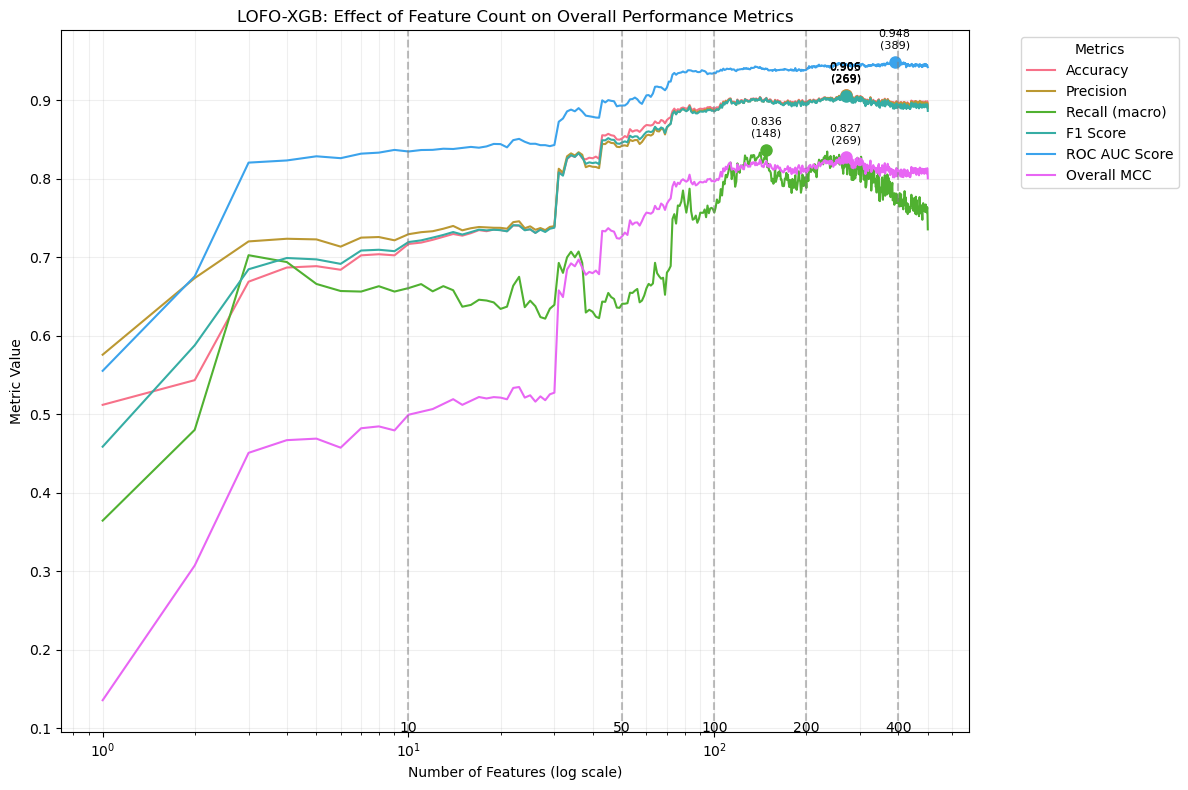

In [7]:
merged['Feature Count'] = merged['Model'].astype(int)

# Init the plot.
plt.figure(figsize=(12, 8))

# Set the seaborn style.
colors = sns.color_palette("husl", n_colors=len(merged.columns[1:-1]))

# Iterate over every model and plot the metrics.
for i, column in enumerate(merged.columns[1:-1]): 
    plt.plot(merged['Feature Count'], merged[column], label=column, color=colors[i])
    
    # Add a marker for the maximum value for each metric.
    max_value = merged[column].max()
    max_index = merged[column].idxmax()
    max_feature_count = merged.loc[max_index, 'Feature Count']
    plt.plot(max_feature_count, max_value, 'o', color=colors[i], markersize=8)
    plt.annotate(f'{max_value:.3f}\n({max_feature_count})', 
                 (max_feature_count, max_value),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=8)

# I chose log scale due to large range of feature counts.
plt.xscale('log') 
plt.xlabel('Number of Features (log scale)')
plt.ylabel('Metric Value')
plt.title('LOFO-XGB: Effect of Feature Count on Overall Performance Metrics')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.2)
for count in [10, 50, 100, 200, 400]:
    plt.axvline(x=count, color='gray', linestyle='--', alpha=0.5)
    plt.text(count, plt.ylim()[0], str(count), horizontalalignment='center')

plt.tight_layout()
plt.show()

In [8]:
def get_best_feature_count(data, metric):
    """
    Extract the feature count with the highest score for a given metric.
    """
    max_index = data[metric].idxmax()
    return data.loc[max_index, 'Feature Count'], data.loc[max_index, metric]

# Init the table.
table = PrettyTable()
table.field_names = ["Metric", "Best Feature Count", "Best Score"]

# List of metrics.
metrics = [col for col in merged.columns if col not in ['Model', 'Feature Count']]

# Add each one to the table.
for metric in metrics:
    best_count, best_score = get_best_feature_count(merged, metric)
    table.add_row([
        metric,
        f"{best_count}",
        f"{best_score:.3f}"
    ])

print(table)

+----------------+--------------------+------------+
|     Metric     | Best Feature Count | Best Score |
+----------------+--------------------+------------+
|    Accuracy    |        269         |   0.906    |
|   Precision    |        269         |   0.906    |
| Recall (macro) |        148         |   0.836    |
|    F1 Score    |        269         |   0.905    |
| ROC AUC Score  |        389         |   0.948    |
|  Overall MCC   |        269         |   0.827    |
+----------------+--------------------+------------+


### Next, plot graphs for all four class-wise metrics for each model.

In [39]:
""" First, need to extract the AP columns from the overall report to match format of other metrics."""
file_path = 'metrics/report/overall_report_with_ap.csv'
df = pd.read_csv(file_path)

# AP columns
selected_columns = ['Model', 'GOF AP', 'LOF AP', 'Neutral AP']
df_selected = df[selected_columns]

# Report.
output_path = 'metrics/report/merged_AP_report.csv'
df_selected.to_csv(output_path, index=False)

print(f"Saved to {output_path}")

Saved to metrics/report/merged_AP_report.csv


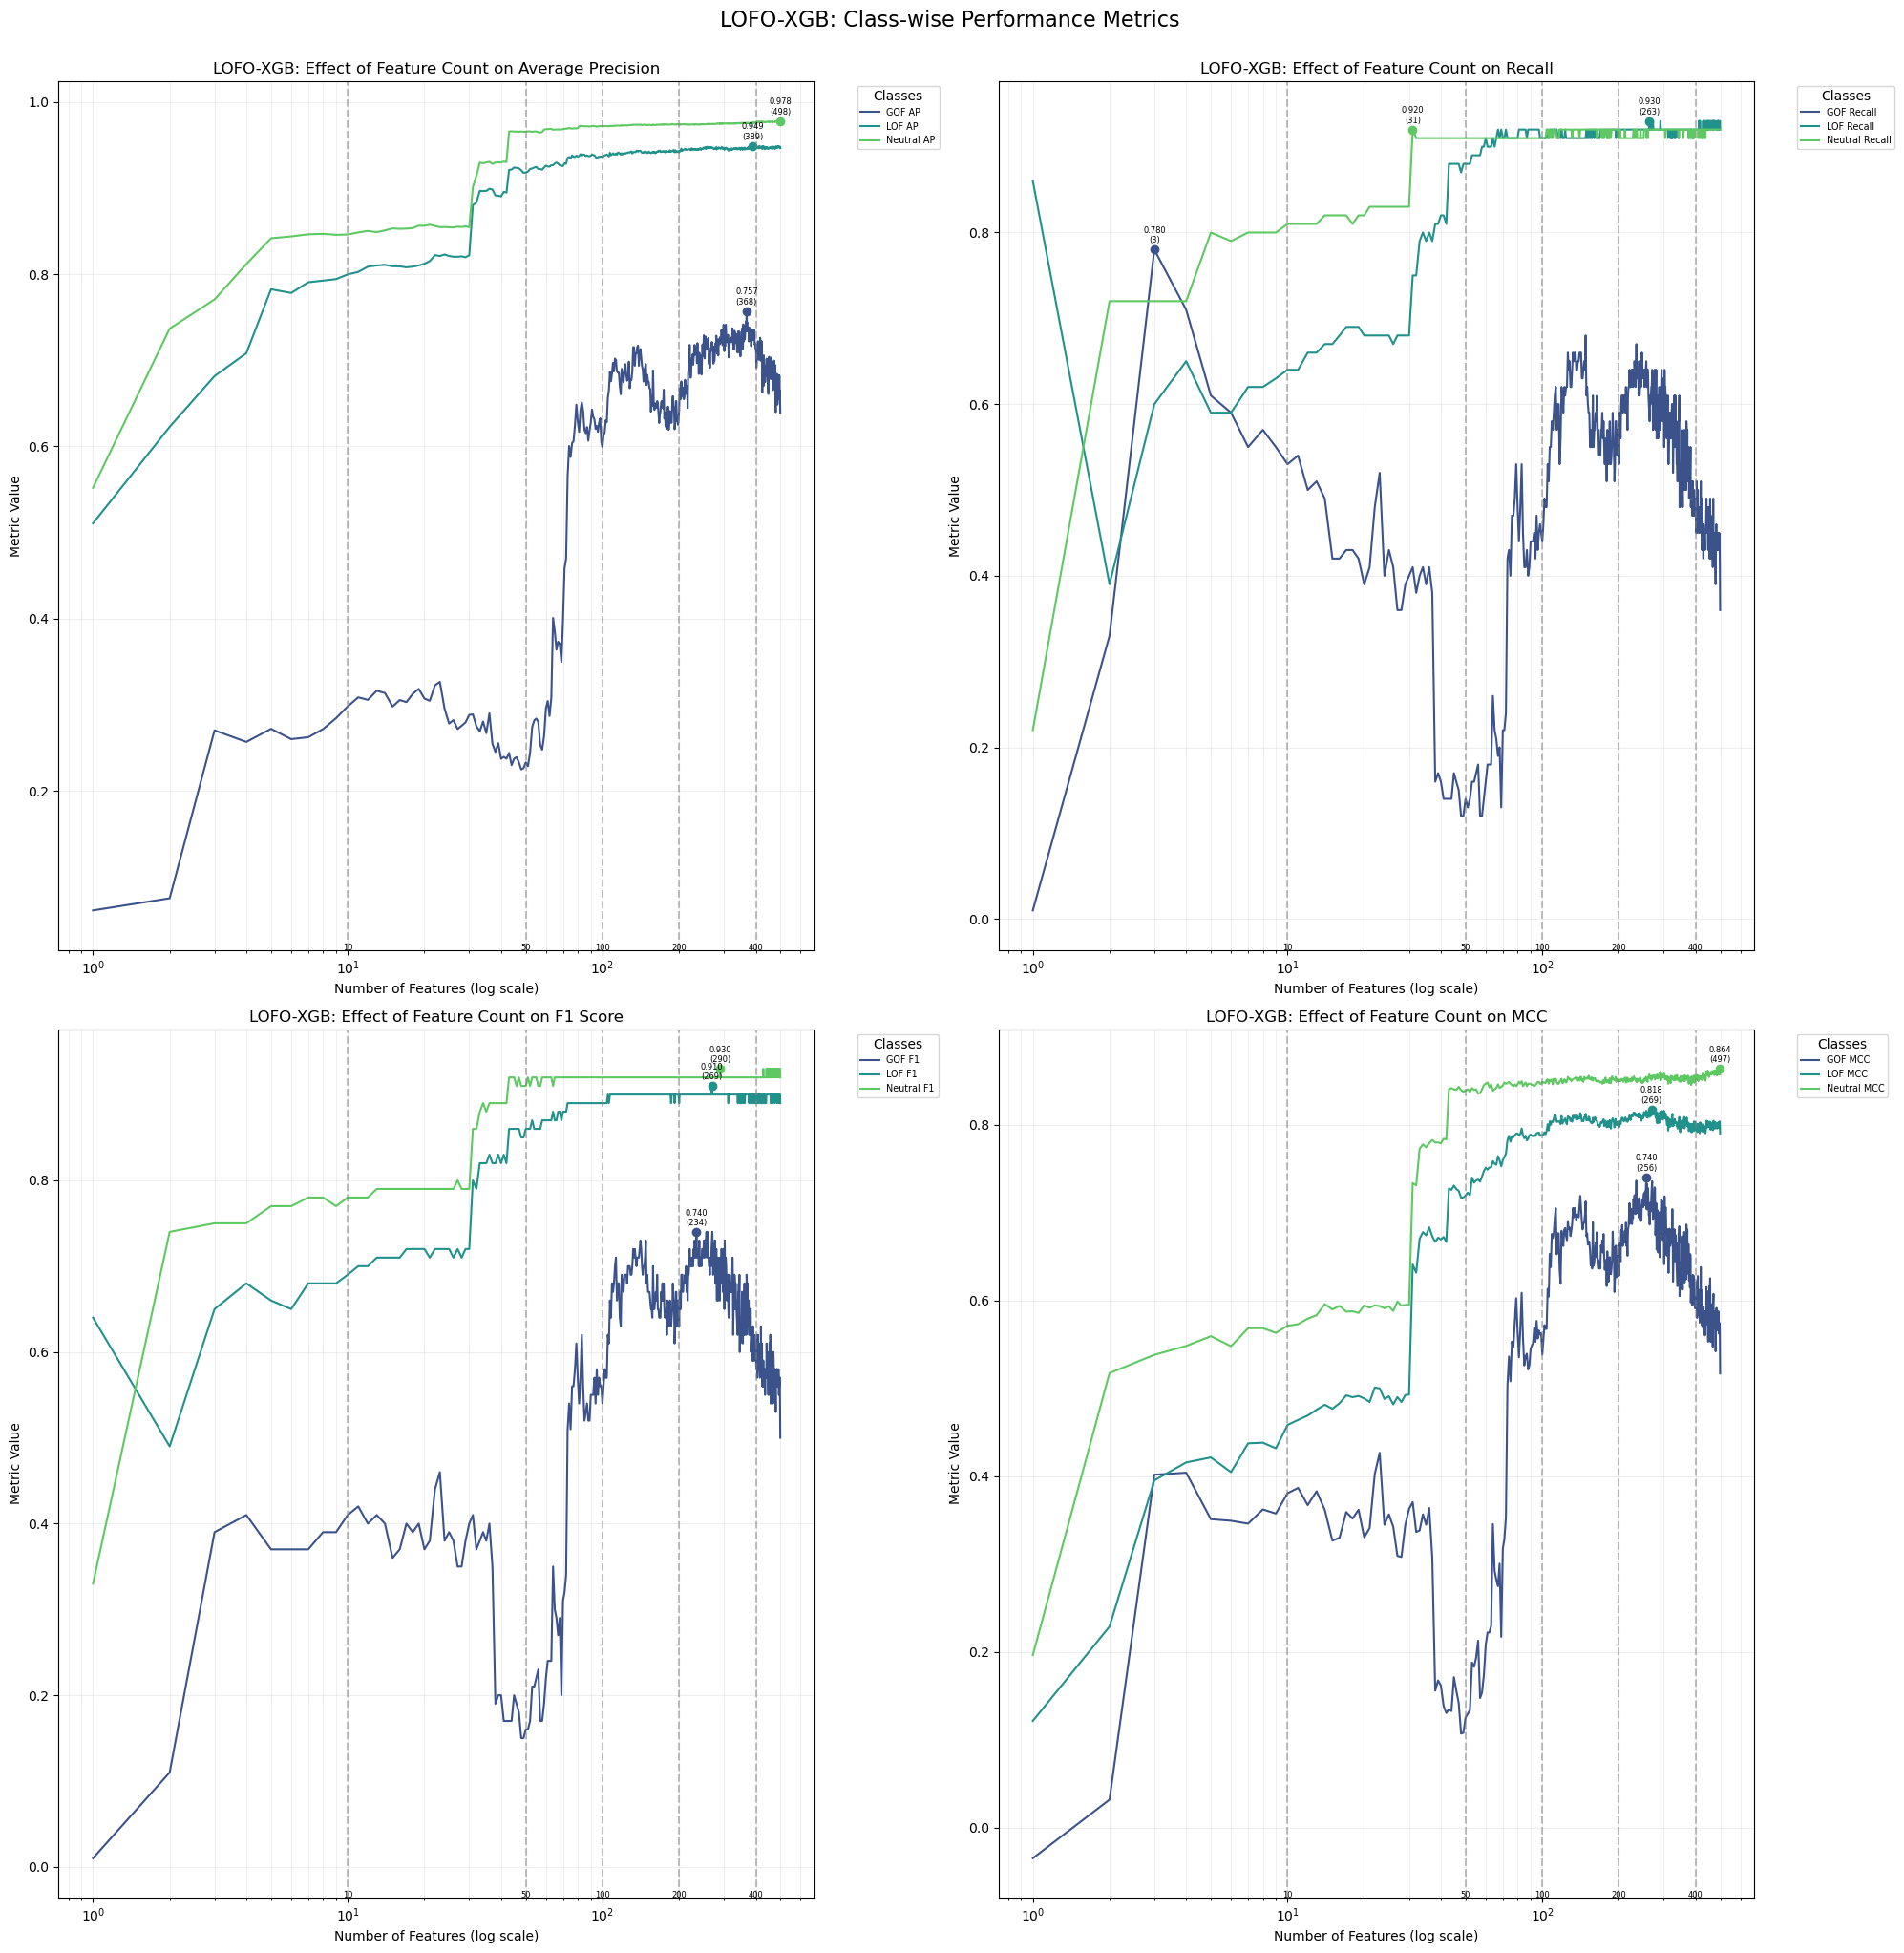

In [6]:
def do_columns(df, metric):
    """
    This ensures that classes appear in the same color order for each metric.
    """
    if metric == 'mcc':
        ordered_columns = ['Model', 'GOF MCC', 'LOF MCC', 'Neutral MCC']
    elif metric == 'ap':
        ordered_columns = ['Model', 'GOF AP', 'LOF AP', 'Neutral AP']
    else:
        ordered_columns = ['Model', f'GOF {metric.capitalize()}', f'LOF {metric.capitalize()}', f'Neutral {metric.capitalize()}']
    return df[ordered_columns]

def do_subplot(ax, data, title, color_dict):
    """
    This generates subplots for each metric.
    """
    class_columns = [col for col in data.columns if col != 'Model' and col != 'Feature Count']
    for column in class_columns:
        color = color_dict[column.split()[0]]
        ax.plot(data['Feature Count'], data[column], label=column, color=color)
        max_value = data[column].max()
        max_index = data[column].idxmax()
        max_feature_count = data.loc[max_index, 'Feature Count']
        ax.plot(max_feature_count, max_value, 'o', color=color, markersize=6)
        ax.annotate(f'{max_value:.3f}\n({max_feature_count})',
                    (max_feature_count, max_value),
                    textcoords="offset points",
                    xytext=(0,5),
                    ha='center',
                    fontsize=6)

    ax.set_xscale('log')
    ax.set_xlabel('Number of Features (log scale)')
    ax.set_ylabel('Metric Value')
    ax.set_title(title)
    ax.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    for count in [10, 50, 100, 200, 400]:
        ax.axvline(x=count, color='gray', linestyle='--', alpha=0.5)
        ax.text(count, ax.get_ylim()[0], str(count), horizontalalignment='center', fontsize=6)

# This draws the figure.
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Points to the metric files.
metrics = [
    ('ap', 'metrics/report/merged_AP_report.csv', 'Average Precision'),
    ('recall', 'metrics/report/merged_recall_report.csv', 'Recall'),
    ('f1', 'metrics/report/merged_f1_report.csv', 'F1 Score'),
    ('mcc', 'metrics/report/merged_mcc_report.csv', 'MCC')
]

# Choose colors for classes.
viridis_palette = sns.color_palette('viridis', 3)  
color_dict = {
    'GOF': viridis_palette[0],
    'LOF': viridis_palette[1],
    'Neutral': viridis_palette[2]
}

# Plot each metric.
for i, (metric, file_name, title) in enumerate(metrics):
    data = pd.read_csv(file_name)
    data = do_columns(data, metric)
    data['Feature Count'] = data['Model'].astype(int)
    
    row = i // 2
    col = i % 2
    do_subplot(axs[row, col], data, f'LOFO-XGB: Effect of Feature Count on {title}', color_dict)
    
plt.tight_layout()
fig.suptitle('LOFO-XGB: Class-wise Performance Metrics', fontsize=16, y=1.02)
plt.show()

In [9]:
def get_best_feature_counts(data, metric):
    """
    Extract the feature counts with the highest score for each class.
    """
    class_columns = [col for col in data.columns if col.lower() not in ['model']]
    best_counts = {}
    for column in class_columns:
        max_index = data[column].idxmax()
        best_counts[column.lower()] = (data.loc[max_index, 'model'], data.loc[max_index, column])
    return best_counts

metrics = [
    ('ap', 'metrics/report/merged_AP_report.csv', 'Average Precision'),
    ('recall', 'metrics/report/merged_recall_report.csv', 'Recall'),
    ('f1', 'metrics/report/merged_f1_report.csv', 'F1 Score'),
    ('mcc', 'metrics/report/merged_mcc_report.csv', 'MCC')
]

# init table.
table = PrettyTable()
table.field_names = ["Metric", "GOF", "LOF", "Neutral"]

# add to table.
for metric, file_name, title in metrics:
    data = pd.read_csv(file_name)
    data.columns = [col.lower() for col in data.columns] 
    
    best_counts = get_best_feature_counts(data, metric)
    table.add_row([
        title,
        f"{best_counts[f'gof {metric}'][0]} ({best_counts[f'gof {metric}'][1]:.3f})",
        f"{best_counts[f'lof {metric}'][0]} ({best_counts[f'lof {metric}'][1]:.3f})",
        f"{best_counts[f'neutral {metric}'][0]} ({best_counts[f'neutral {metric}'][1]:.3f})"
    ])

print(table)

+-------------------+-------------+-------------+-------------+
|       Metric      |     GOF     |     LOF     |   Neutral   |
+-------------------+-------------+-------------+-------------+
| Average Precision | 368 (0.757) | 389 (0.949) | 498 (0.978) |
|       Recall      |  3 (0.780)  | 263 (0.930) |  31 (0.920) |
|      F1 Score     | 234 (0.740) | 269 (0.910) | 290 (0.930) |
|        MCC        | 256 (0.740) | 269 (0.818) | 497 (0.864) |
+-------------------+-------------+-------------+-------------+
